<a href="https://colab.research.google.com/github/bubuloMallone/NeuralNetworksLM/blob/main/mlp_internals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
!wget https://raw.githubusercontent.com/bubuloMallone/NeuralNetworksLM/refs/heads/main/datasets/names.txt

words = open('names.txt', 'r').read().splitlines()

words[:10]

--2025-07-11 12:33:40--  https://raw.githubusercontent.com/bubuloMallone/NeuralNetworksEX/refs/heads/main/datasets/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2025-07-11 12:33:40 (8.03 MB/s) - ‘names.txt’ saved [228145/228145]



['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [ ]:
chars = sorted(list(set(''.join(words))))
alphabet_size = len(chars) + 1
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(alphabet_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset

# define the context length: how many char we consider to predict the next one
block_size = 3

def build_dataset(words):
  X, Y = [], []

  for word in words:

    context = [0] * block_size
    for ch in word + '.':
      idx = stoi[ch]
      X.append(context)
      Y.append(idx)
      # print(''.join(itos[i] for i in context), '--->', itos[idx])
      context = context[1:] + [idx]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print('Data:', X.shape, X.dtype)
  print('Labels:', Y.shape, Y.dtype)
  num_samples = X.shape[0]

  return X, Y, num_samples


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr, num_samples_tr = build_dataset(words[:n1])
Xval, Yval, num_samples_val = build_dataset(words[n1:n2])
Xte, Yte, num_samples_te = build_dataset(words[n2:])

Data: torch.Size([182625, 3]) torch.int64
Labels: torch.Size([182625]) torch.int64
Data: torch.Size([22655, 3]) torch.int64
Labels: torch.Size([22655]) torch.int64
Data: torch.Size([22866, 3]) torch.int64
Labels: torch.Size([22866]) torch.int64


# Initialization and its impacts on training performances

**Note 1**: Avoid high initial random logits.

Initialize W2,b2 properly!

In [ ]:
# We want that at initialization the network assigns equal probabilities to all characters
# the expected inital loss should be something similar to
print(-torch.tensor(1/float(alphabet_size)).log())

tensor(3.2958)


In [ ]:
# at initialization instead the network is creating probs that are all messed up, i.e. some are very confident andd some are very confidently wrong.
# example: let us suppose the idx=2 is the correct label to predict
idx = 2
print('correct label: ', idx)

logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = F.softmax(logits, dim=0)
loss = -probs[idx].log()
print('logits: ', logits)
print('probs: ', probs)
print('loss: ', loss)

logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = F.softmax(logits, dim=0)
loss = -probs[idx].log()
print('logits: ', logits)
print('probs: ', probs)
print('loss: ', loss)

logits = torch.tensor([-3.0, 7.0, 1.0, 2.0])
probs = F.softmax(logits, dim=0)
loss = -probs[idx].log()
print('logits: ', logits)
print('probs: ', probs)
print('loss: ', loss)

logits = torch.randn(4) * 20
probs = F.softmax(logits, dim=0)
loss = -probs[idx].log()
print('logits: ', logits)
print('probs: ', probs)
print('loss: ', loss)

# therefore if the initial logits are relatively big random numbers then the loss will be very high
# we want the inital logits to be close to zero even though still random

correct label:  2
logits:  tensor([0., 0., 0., 0.])
probs:  tensor([0.2500, 0.2500, 0.2500, 0.2500])
loss:  tensor(1.3863)
logits:  tensor([0., 0., 5., 0.])
probs:  tensor([0.0066, 0.0066, 0.9802, 0.0066])
loss:  tensor(0.0200)
logits:  tensor([-3.,  7.,  1.,  2.])
probs:  tensor([4.4983e-05, 9.9082e-01, 2.4560e-03, 6.6761e-03])
loss:  tensor(6.0092)
logits:  tensor([-29.1832, -34.9111, -14.7261,  -3.0207])
probs:  tensor([4.3429e-12, 1.4131e-14, 8.2490e-06, 9.9999e-01])
loss:  tensor(11.7054)


In [ ]:
# MLP architecture

g = torch.Generator().manual_seed(2147483647)

emb_dim = 10
hidden_dim = 200

# embedding
C = torch.randn((alphabet_size, emb_dim))
# first fully connected layer
W1 = torch.randn((block_size * emb_dim, hidden_dim), generator=g) * (5/3)/((block_size * emb_dim)**0.5) # Kaiming init for tanh! * 0.2  # to avoid dead neurons
b1 = torch.randn(hidden_dim, generator=g) * 0.01  # to avoid dead neurons
# second fully connected layer
W2 = torch.randn((hidden_dim, alphabet_size), generator=g) * 0.01  # to keep low initial logits
# note better not to set W2 exactly to zero!
b2 = torch.randn(alphabet_size, generator=g) * 0   # to keep low initial logits

parameters = [C, W1, b1, W2, b2]

# require gradients
for p in parameters:
  p.requires_grad = True

tot_parameters = sum(p.nelement() for p in parameters)
print(f'Total number of parameters: {tot_parameters}')

Total number of parameters: 11897


In [ ]:
max_steps = 200000
batch_size = 32
losses = []

for i in range(max_steps):

  # minibatch construct
  idxs = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)  # (num_samples,) --> (batch_size,)
  Xb, Yb = Xtr[idxs], Ytr[idxs]  # (batch_size, block_size) and (batch_size,)

  # forward pass
  emb = C[Xb]   # (batch_size, block_size, emb_dim)
  emb_cat = emb.view(emb.shape[0], -1)  # (batch_size, block_size * emb_dim)
  h_preact = emb_cat @ W1 + b1   # (batch_size, hidden_dim)
  h = torch.tanh(h_preact)   # (batch_size, hidden_dim)
  logits = h @ W2 + b2    # (batch_size, alphabet_size)
  loss = F.cross_entropy(logits, Yb)
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  learning_rate = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -learning_rate * p.grad

  # track stats
  if i % 10000 == 0 : # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  losses.append(loss.log10().item())

 # break

      0/ 200000: 3.3228


**Note 2**: Non-linerarity of the hidden layer might kill gradients!

The initialization of the weight and biases could be such that the hidden layer has dead neurons, i.e. neurons that never activate. This happens when the pre-activation of the neuron yield to a flat tail of the activation function, with vanishing gradient, no matter what the input sample is. This means the dead neuron will never learn the weights and biases on the data.

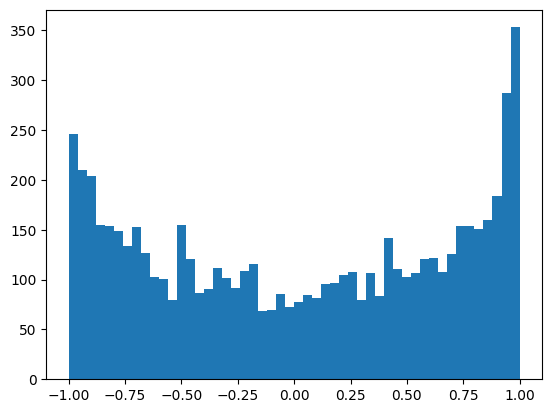

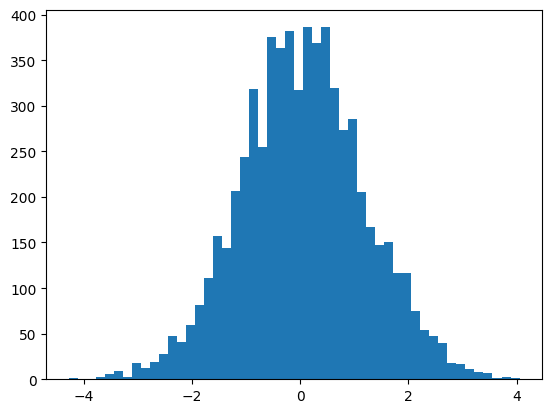

In [ ]:
plt.hist(h.view(-1).tolist(), bins=50)
plt.show()

plt.hist(h_preact.view(-1).tolist(), bins=50)
plt.show()

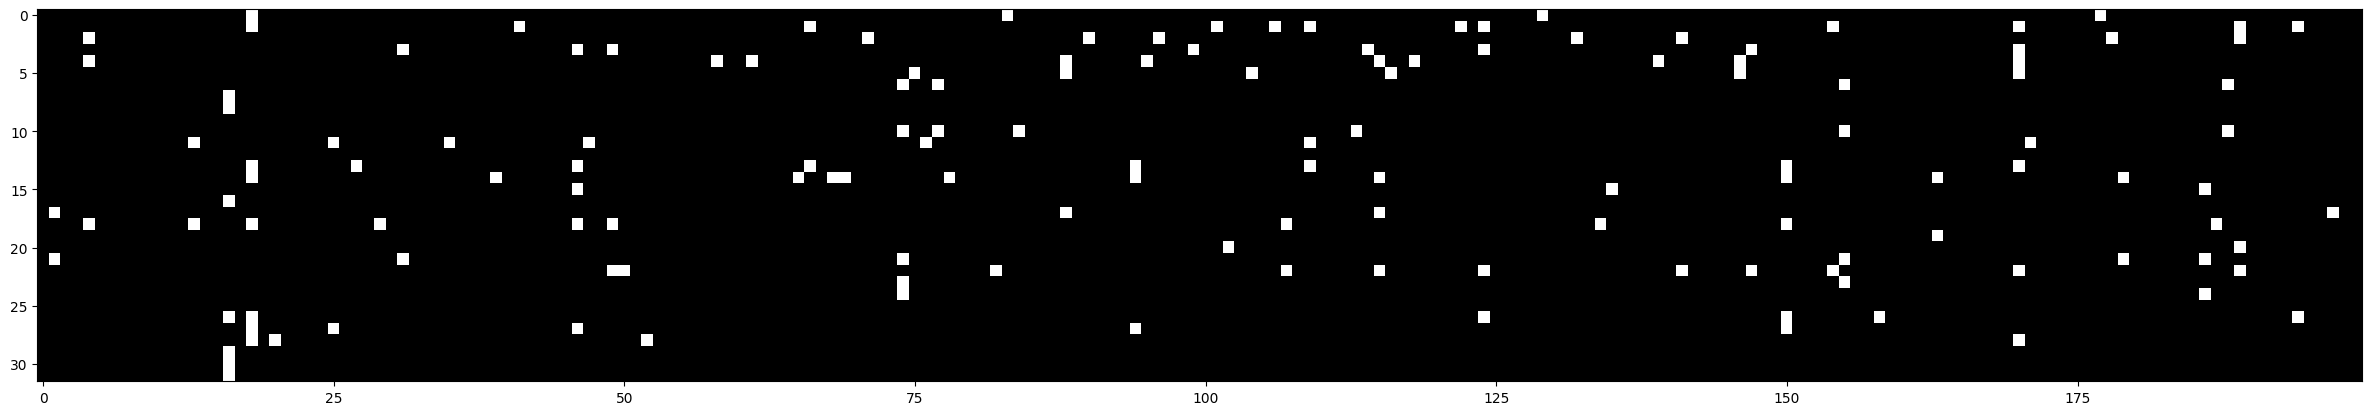

In [ ]:
plt.figure(figsize=(30,15))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.show()

# Again we want the initialized preactivation to stay close to zero
# so that the non-linearity is not saturated and the gradients are not vanishing.

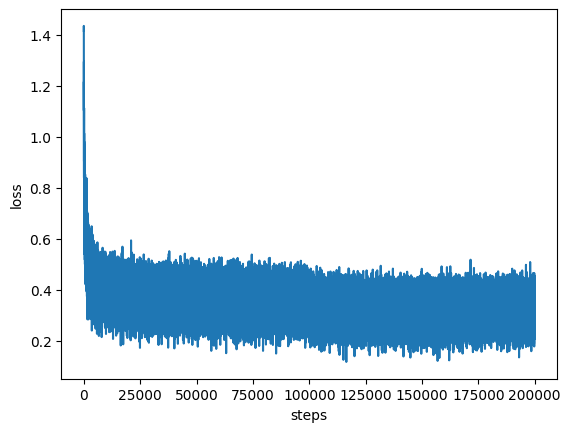

In [ ]:
plt.plot(losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()

**Evaluate the the model on a set**

In [ ]:
# evaluate the model on a set

@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]

  # forward pass
  emb = C[x]   # (set_size, block_size, emb_dim)
  h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)   # (set_size, hidden_dim)
  logits = h @ W2 + b2    # (set_size, alphabet_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 3.309002161026001
val 3.309101104736328


# Batch Normalization

A modern and more powerful way to control the scale of the pre-activations through out the neural network and avoid the saturation of the activations is to introduce Batch Normalization routines after the linear layers and before the activations. This basically means to impose normal gaussian distribution of the pre-activations over the batch samples at the moment of initialization, for each neuron of the layer. Then is useful to introduce trainable gain and bias parameters to allow the modulation of this distribution in terms of mean and standard deviation during training. This can be done because the operation of centering to have gaussian activation is differentiable.

Note: the batch normalization is an operation that couples the batch samples together. Indeed the pre-activations and then the logits are now function of all the batch samples, and not anymore function of a single sample. This might seems as an unwanted noisy effect, that surprisingly is improving the training by acting ad a regularization of the samples.

In [ ]:
# MLP architecture

g = torch.Generator().manual_seed(2147483647)

emb_dim = 10
hidden_dim = 200

# embedding
C = torch.randn((alphabet_size, emb_dim))
# first fully connected layer
W1 = torch.randn((block_size * emb_dim, hidden_dim), generator=g) # the Kaiming init for activationis not needed anymore
# Note: the bias b1 is not needed anymore since is the averaged out by batch norm. It is replaced by batch_norm_bias
# b1 = torch.randn(hidden_dim, generator=g) * 0.01
# second fully connected layer
W2 = torch.randn((hidden_dim, alphabet_size), generator=g) * 0.01  # to keep low initial logits
# note better not to set W2 exactly to zero!
b2 = torch.randn(alphabet_size, generator=g) * 0   # to keep low initial logits

# batch norm parameters
batch_norm_gain = torch.ones((1, hidden_dim))
batch_norm_bias = torch.zeros((1, hidden_dim))
# estimate a running mean to and std to use then in evaluation after training
bn_mean_running = torch.zeros((1, hidden_dim))
bn_std_running = torch.ones((1, hidden_dim))

parameters = [C, W1, W2, b2, batch_norm_gain, batch_norm_bias]

# require gradients
for p in parameters:
  p.requires_grad = True

tot_parameters = sum(p.nelement() for p in parameters)
print(f'Total number of parameters: {tot_parameters}')

Total number of parameters: 12297


In [ ]:
max_steps = 200000
batch_size = 32
losses = []

for i in range(max_steps):

  # minibatch construct
  idxs = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)  # (num_samples,) --> (batch_size,)
  Xb, Yb = Xtr[idxs], Ytr[idxs]  # (batch_size, block_size) and (batch_size,)

  # Forward pass
  emb = C[Xb]   # (batch_size, block_size, emb_dim)
  emb_cat = emb.view(emb.shape[0], -1)  # (batch_size, block_size * emb_dim)
  # linear layer
  h_preact = emb_cat @ W1 + b1   # (batch_size, hidden_dim)
  # batch norm layer
  bn_mean_i = h_preact.mean(0, keepdim=True)
  bn_std_i = h_preact.std(0, keepdim=True)
  h_preact = batch_norm_gain * ((h_preact - bn_mean_i) / bn_std_i) + batch_norm_bias   # normalize the batch to unit gaussian and then offset/scale it according to learned bn_bias/gain (might add +eps small to std)
  with torch.no_grad():
    bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i  # estimate running mean/std for later inference
    bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i    # 0.001 is the 'momentum'
  # non-linear activation
  h = torch.tanh(h_preact)   # (batch_size, hidden_dim)
  # output layer
  logits = h @ W2 + b2    # (batch_size, alphabet_size)
  loss = F.cross_entropy(logits, Yb)

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  learning_rate = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -learning_rate * p.grad

  # track stats
  if i % 10000 == 0 : # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  losses.append(loss.log10().item())


      0/ 200000: 3.3337


In [ ]:
# evaluate the model on a set

@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]

  # forward pass
  emb = C[x]   # (set_size, block_size, emb_dim)
  emb_cat = emb.view(emb.shape[0], -1)  # (set_size, block_size * emb_dim)
  h_preact = emb_cat @ W1 + b1   # (set_size, hidden_dim)
  # use the running mean estimation (over all training set) of the batch_norm mean/std for inference
  h_preact = batch_norm_gain * (h_preact - bn_mean_running) / bn_std_running + batch_norm_bias   # batch normalization
  h = torch.tanh(h_preact)   # (set_size, hidden_dim)
  logits = h @ W2 + b2    # (set_size, alphabet_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 3.309002161026001
val 3.309101104736328


# PyTorch-ifying the neural network

We can now train a deeper neural network structuring everyting in terms of classes. These classes we create here are the same API as in the 'nn.' Module in PyTorch.

In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn(fan_in, fan_out) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
      return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gain = torch.ones(dim)
    self.bias = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gain * xhat + self.bias
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gain, self.bias]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gain *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2896


Check the saturation of the non-linear activations through the network.

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 3.03%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.75%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.59%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.34%
layer 14 (      Tanh): mean -0.00, std 0.66, saturated: 1.56%


Text(0.5, 1.0, 'activation distribution')

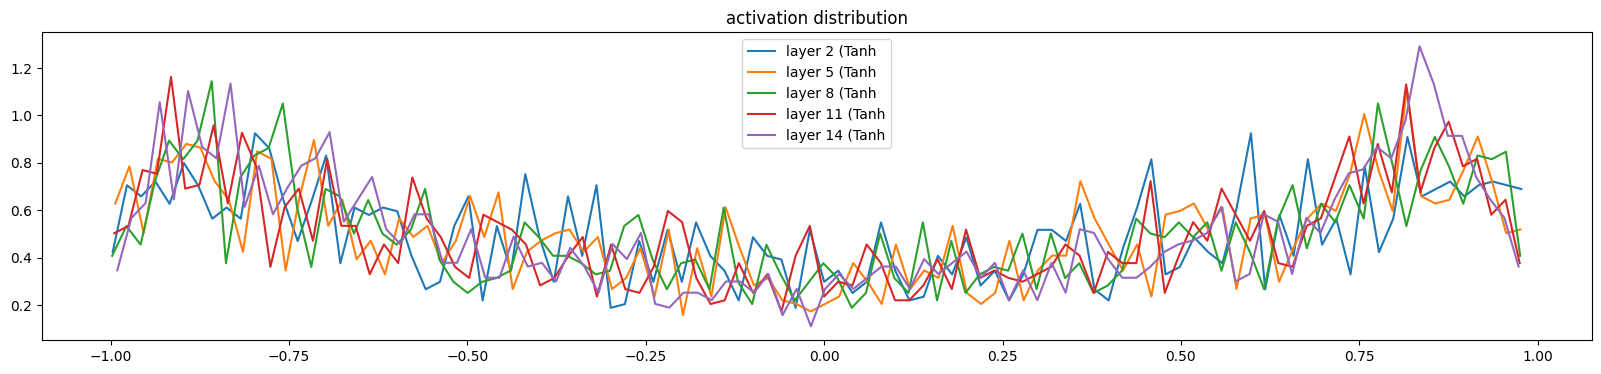

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

Check the distribution of the gradients of activations through the network.

layer 2 (      Tanh): mean +0.000000, std 2.230090e-03
layer 5 (      Tanh): mean +0.000000, std 1.992792e-03
layer 8 (      Tanh): mean -0.000000, std 1.963263e-03
layer 11 (      Tanh): mean -0.000000, std 1.875085e-03
layer 14 (      Tanh): mean -0.000000, std 1.808948e-03


Text(0.5, 1.0, 'gradient distribution')

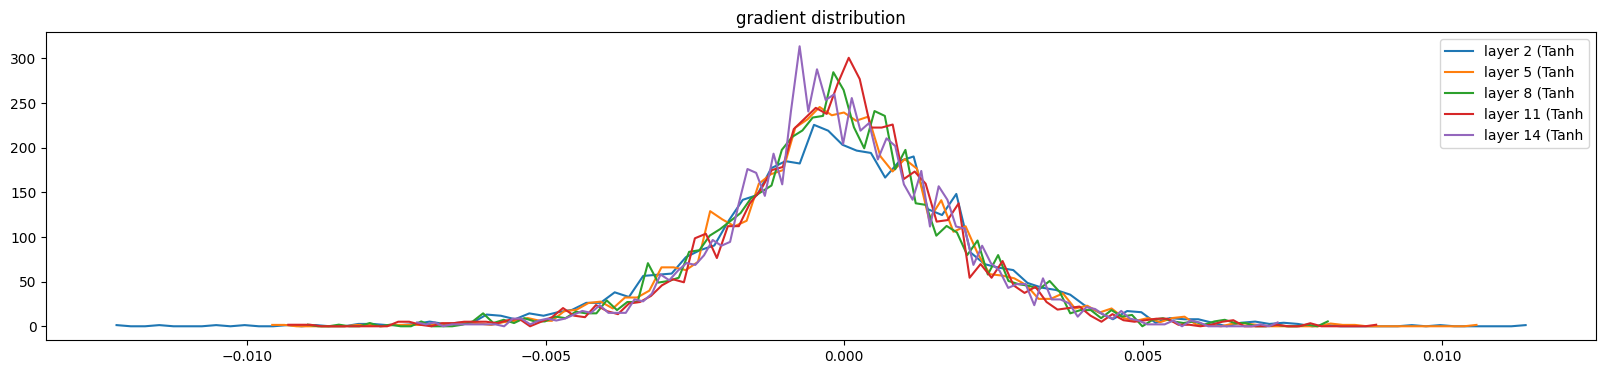

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

Check also the weights of the layers over the network. In particulat we can look at their gradients distribution. Also can look at the the gradient to data Ratio that tell what is the scale of the weights gradients woth respect to the scale of data. This gives an idea of the pace at which optimization goes in every layer.

weight   (27, 10) | mean +0.000000 | std 7.899766e-03 | grad:data ratio 7.891841e-03
weight  (30, 100) | mean +0.000066 | std 8.470013e-03 | grad:data ratio 4.609608e-02
weight (100, 100) | mean +0.000009 | std 6.109699e-03 | grad:data ratio 5.939797e-02
weight (100, 100) | mean -0.000160 | std 5.835938e-03 | grad:data ratio 5.725408e-02
weight (100, 100) | mean +0.000030 | std 5.479475e-03 | grad:data ratio 5.423723e-02
weight (100, 100) | mean +0.000028 | std 4.897881e-03 | grad:data ratio 4.835929e-02
weight  (100, 27) | mean -0.000178 | std 9.040098e-03 | grad:data ratio 8.595256e-02


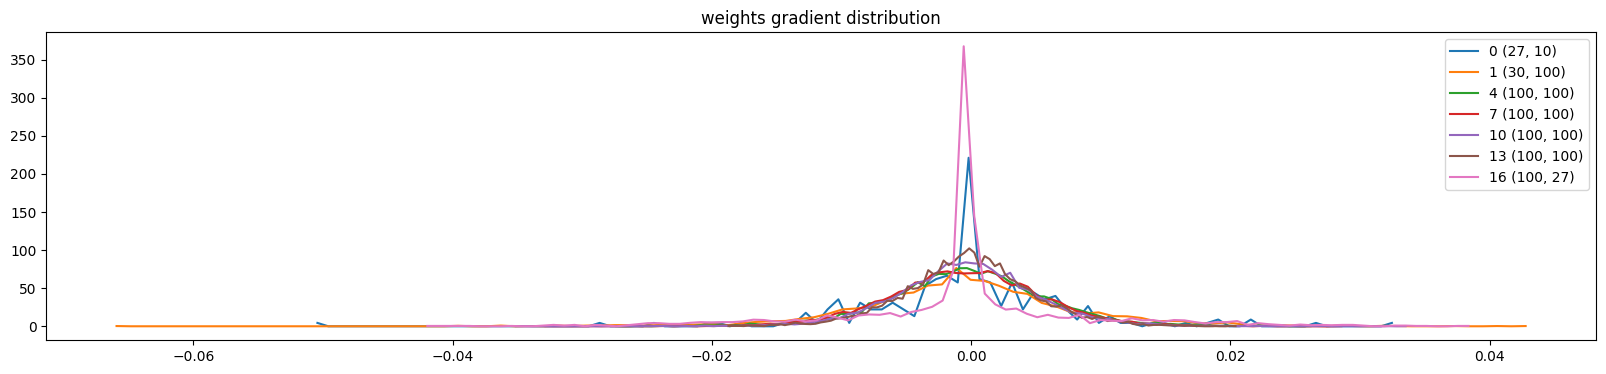

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

Even more informative is the update to data ratio, which gives information of the scale of the actual update, given by learning rate times gradient, with respect to the scale of data. These ratios should be around 1e-3 indicatively.

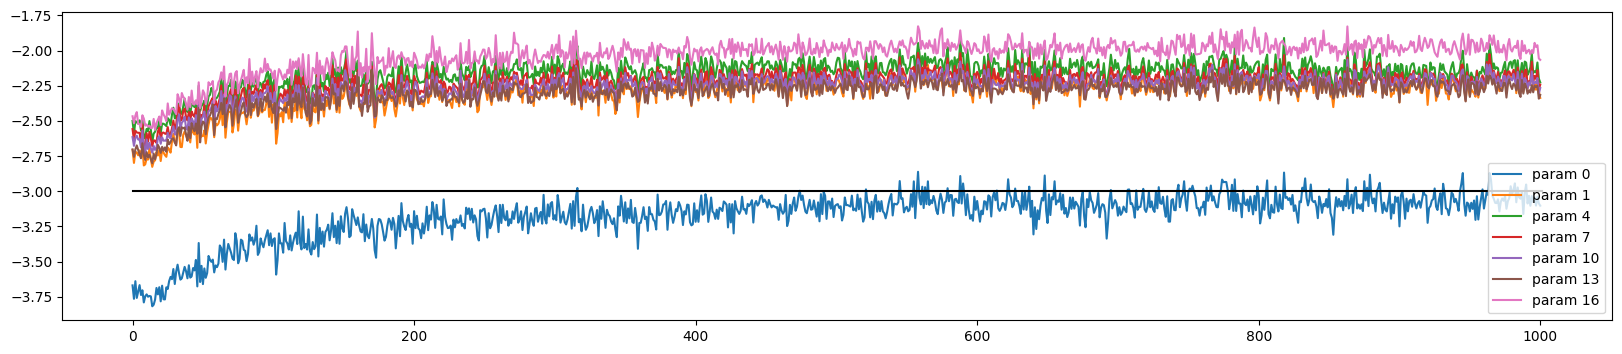

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title('update to data ratios');

# Sampling from the model

In [ ]:
# sampling from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size   # initialize the sampling context with "..."
  while True:
    emb = C[torch.tensor([context])] # (1, block_size, d)
    emb_cat = emb.view(emb.shape[0], -1)  # (1, block_size * emb_dim)
    h_preact = emb_cat @ W1 + b1   # (1, hidden_dim)
    h_preact = batch_norm_gain * (h_preact - h_preact.mean(0, keepdim=True)) / h_preact.std(0, keepdim=True) + batch_norm_bias   # batch normalization
    h = torch.tanh(h_preact)   # (1, hidden_dim)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    idx = torch.multinomial(probs, num_samples=1, replacement = True, generator=g).item()
    context = context[1:] + [idx]
    out.append(idx)
    if idx == 0:
      break

  print(''.join(itos[i] for i in out))

mora.
mayannieel.
nihriah.
remyra.
endraega.
zeredgeliah.
milopa.
eden.
estanar.
katelmonter.
noshub.
rishiriel.
kin.
reelynn.
noella.
uzabelder.
yarleyeh.
yuma.
miston.
mahil.
